## Prepare Notebook

In [1]:
import numpy as np
import scipy.stats as ss
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Get TensorFlow version.
print(f'TnesorFlow version: {tf.__version__}')
print(f'TnesorFlow Probability version: {tfp.__version__}')

TnesorFlow version: 2.2.0
TnesorFlow Probability version: 0.10.0


In [2]:
tf.random.set_seed(seed=42)

n = 100
rate_true = 2.0
poisson_true = tfd.Poisson(rate=rate_true)

poisson_samples = poisson_true.sample(sample_shape=n)

poisson_samples 

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([3., 3., 3., 1., 2., 1., 2., 0., 0., 2., 2., 1., 2., 2., 0., 3., 1.,
       4., 1., 1., 2., 0., 3., 4., 1., 3., 1., 2., 2., 0., 0., 2., 1., 1.,
       3., 5., 4., 3., 1., 4., 2., 2., 0., 2., 2., 4., 4., 2., 0., 4., 2.,
       4., 1., 1., 2., 1., 1., 1., 4., 1., 3., 3., 1., 3., 0., 1., 1., 3.,
       5., 1., 2., 2., 4., 0., 2., 3., 1., 3., 2., 4., 2., 2., 3., 2., 1.,
       3., 1., 1., 0., 1., 2., 1., 2., 3., 4., 3., 2., 1., 0., 1.],
      dtype=float32)>

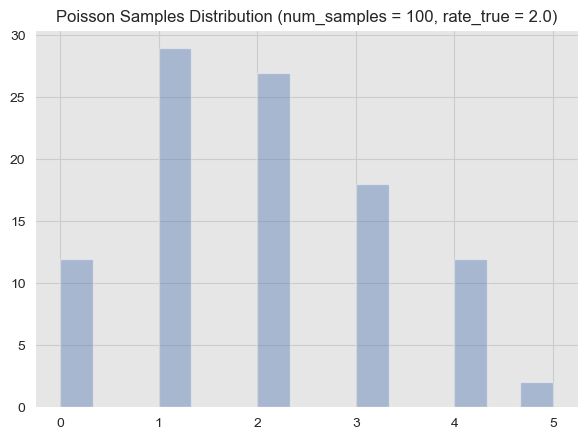

In [3]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.distplot(a=poisson_samples, bins=15, kde=False, ax=ax)
ax.set(title=f'Poisson Samples Distribution (num_samples = {n}, rate_true = {rate_true})');

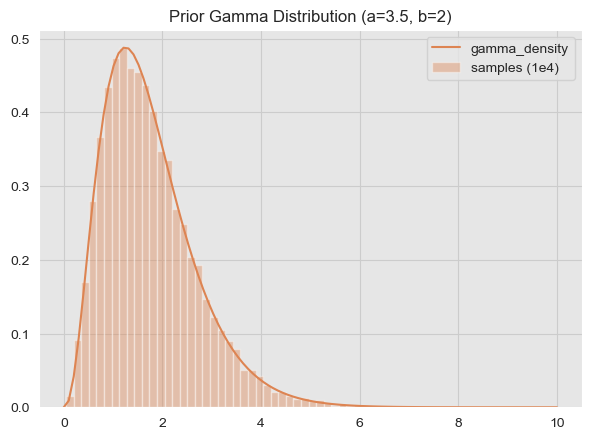

In [4]:
a = 3.5
b = 2

gamma_prior = tfd.Gamma(concentration=a, rate=b)

x = np.linspace(start=0, stop=10, num=100)

fig, ax = plt.subplots(figsize=(7, 5))

sns.distplot(
    a=gamma_prior.sample(sample_shape=1e4), 
    color=sns_c[1], 
    kde=False, 
    norm_hist=True, 
    label='samples (1e4)', 
    ax=ax
)
sns.lineplot(
    x=x, 
    y=ss.gamma.pdf(x,a=a,scale=1/b), 
    color=sns_c[1], 
    label='gamma_density', 
    ax=ax
)
ax.legend()
ax.set(title=f'Prior Gamma Distribution (a={a}, b={b})');

In [5]:
def build_model(rate, poisson_samples, a=2, b=3.5):
    return tfd.JointDistributionNamed(dict(
        rate=tfd.Gamma(concentration=a, rate=b),
        obs=lambda rate: tfd.Independent(
            tfd.Poisson(rate=[rate]*len(poisson_samples)), 
            reinterpreted_batch_ndims=1
        )
    ))

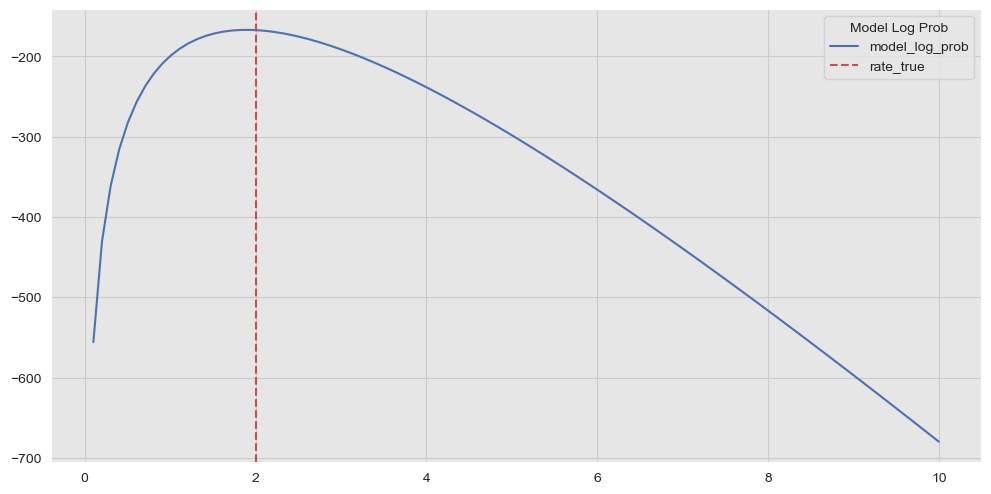

In [6]:
model = build_model(rate=rate_true, poisson_samples=poisson_samples)

rates = np.linspace(start=0.0, stop=10.0, num=100)
model_log_probs = [
    model.log_prob(rate=x, obs=poisson_samples).numpy() 
    for x in rates
]

fig, ax = plt.subplots() 
sns.lineplot(x=rates, y=model_log_probs, color=sns_c[0], label='model_log_prob', ax=ax)
ax.axvline(x=rate_true, linestyle='--', color=sns_c[3], label='rate_true')
ax.legend(loc='upper right')
ax.legend(title='Model Log Prob');

In [7]:
def target_log_prob_fn(rate):
    model = build_model(rate=rate, poisson_samples=poisson_samples)
    return model.log_prob(rate=rate, obs=poisson_samples)


num_results = int(1e4)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=3,
        step_size=1.0
    ),
    num_adaptation_steps=int(num_burnin_steps * 0.8)
)

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.0,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )

  return samples

In [8]:
num_chains = 5
chains = [run_chain() for i in range(num_chains)]

In [9]:
chains_df = pd.DataFrame([t.numpy() for t in chains]) \
    .T \
    .melt(var_name='chain_id', value_name='sample')

chains_df.head()

,chain_id,sample
0,0,2.091923
1,0,2.063448
2,0,2.010697
3,0,2.003116
4,0,2.003116


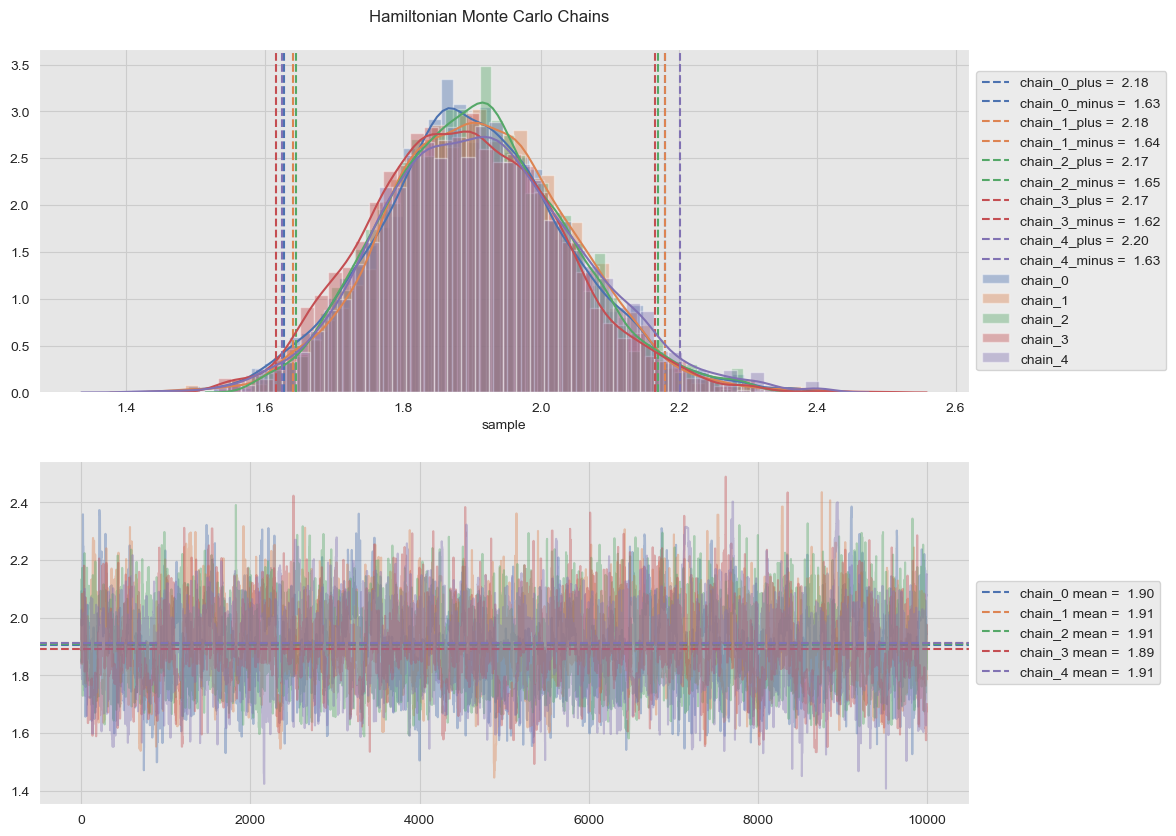

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

for i in range(5):

    chain_samples = chains_df \
        .query(f'chain_id == {i}') \
        .reset_index(drop=True) \
        ['sample']

    chain_samples_mean = chain_samples.mean()
    chain_samples_std = chain_samples.std()
    chain_samples_plus = chain_samples_mean + 2*chain_samples_std
    chain_samples_minus = chain_samples_mean - 2*chain_samples_std

    sns.distplot(a=chain_samples, color=sns_c[i], hist_kws={'alpha': 0.4}, label=f'chain_{i}', ax=ax[0])
    ax[0].axvline(x=chain_samples_plus, linestyle='--', color=sns_c[i], label=f'chain_{i}_plus = {chain_samples_plus: 0.2f}')
    ax[0].axvline(x=chain_samples_minus, linestyle='--', color=sns_c[i], label=f'chain_{i}_minus = {chain_samples_minus: 0.2f}')
    ax[1].plot(chain_samples, c=sns_c[i], alpha=0.4)
    ax[1].axhline(y=chain_samples_mean, linestyle='--', color=sns_c[i], label=f'chain_{i} mean = {chain_samples_mean: 0.2f}')

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.suptitle('Hamiltonian Monte Carlo Chains', y=0.92);